In [78]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from tensorflow import keras
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from joblib import dump, load
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import re
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout

# Modelos de redes neuronales

Apliquemos a continuación Modelos de Redes Neuronales a nuestra serie de tiempo, para conocer el comportamiento del pronóstico que se puede alcanzar a partir de estos. En este apartado estaremos aplicando:

1. Recurrent neural networks
2. Multilayer-perceptron
3. Long-short term memory

Durante el análisis se estarán construyendo modelos para distintas combinaciones de épocas, input layers, neuronas y tasas de drop-out.

Cada una de los apartados a continuación incluyen funciones de creación de la red neuronal, además se diseñó una función que retorna el mejor modelo en cada caso, para automatizar la creación y selección para cada combinación. Carguemos los datos:

In [53]:
df=pd.read_excel("loadsts.xlsx")
df.index = df['Posted_date']
df.index.freq = 'D'
ts = df['Loads']

En el caso de red neuronales, escalaremos los datos con el fin de disminuir el tiempo de alcance de la convergencia.

In [54]:
df['loads_escaler'] = df['Loads']
scaler = MinMaxScaler(feature_range=(0, 1))
ts_esc = scaler.fit_transform(np.array(df['loads_escaler']).reshape(-1, 1))

## 1. Funciones complementarias

Al igual que en los otros capítulos estaremos usando las funciones de apoyo para separación de la serie, evaluación de supuestos y evaluación de los 'score' de pronóstico.

In [38]:
def split(serie, trainportion):
    perct = math.ceil(len(ts) * trainportion)
    perc2 = math.ceil(len(ts)*((1 - trainportion)/2))
    train = serie[0:perct]
    validation = serie[perct:perct+perc2]
    test = serie[perct+perc2:]
    return train, validation, test

In [28]:
#calculo de los errores
def errors(y_pred, y_real):
    
    mae = mean_absolute_error(y_real, y_pred)
    mape = 100*(sum(abs(((y_real - y_pred)/y_real)))/len(y_real))
    mse = mean_squared_error(y_real , y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    
    return mae, mape, mse, rmse, r2

In [48]:
#evaluacion de supuestos
def assumptions(residuals):

    warning = ""
    a = 0
    
    #Independency
    #H0: The residuals are independent.
    #H1: The residuals aren't independent.    
    ljung_box_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    ljung_box_pvalue = ljung_box_test['lb_pvalue'].values[0]
    if ljung_box_pvalue < 0.05:
        warning= warning + " The residuals aren't independent"
        a=a+1

    #Normality test
    #H0: The residuals have a normal distribution.
    #H1: The residuals don't have a normal distribution.
    jb_stat, jb_pvalue, skewness, kurtosis = jarque_bera(residuals)
    if jb_pvalue < 0.05:
        a = a+1
        warning = warning + " The residuals do not follow a normal distribution"

    #homocedasticity
    #H0: The residuals are homocedastic.
    #H1: The residuals aren't homocedastic.
    arch_stat, arch_pvalue, _, _ = het_arch(residuals)
    if arch_pvalue < 0.05:
        warning= warning + " The residuals aren't homocedastic"
        a=a+1

    return arch_pvalue, jb_pvalue, ljung_box_pvalue, warning

Además, agregaremos la función _makeXy_ que se encarga de organizar la serie de tiempo en un arreglo matricial que genera el input layer de $nbtimesteps$ y la predicción $y$ de un valor a la vez. Durante la selección del mejor modelo de cada tipo de red neuronal estaremos probando esta división para los valores de 3, 4, 5 días para entrenar la red.

In [57]:
def makeXy(ts, nbtimesteps):
    X = []
    y = []
    for i in range(nbtimesteps, ts.shape[0]):
        X.append(list(ts[i-nbtimesteps:i-1])) #Regressors
        y.append(ts[i]) #Target
    X, y = np.array(X), np.array(y)
    return X, y

El conjunto de entrenamiento tendrá el 80% datos en este entrenamiento de red neuronal. Guardaremos los conjuntos con los valores reales y los valores escalados a continuación:

In [55]:
train, val, test = split(ts, 0.8)
train_esc, val_esc, test_esc = split(ts_esc, 0.8)

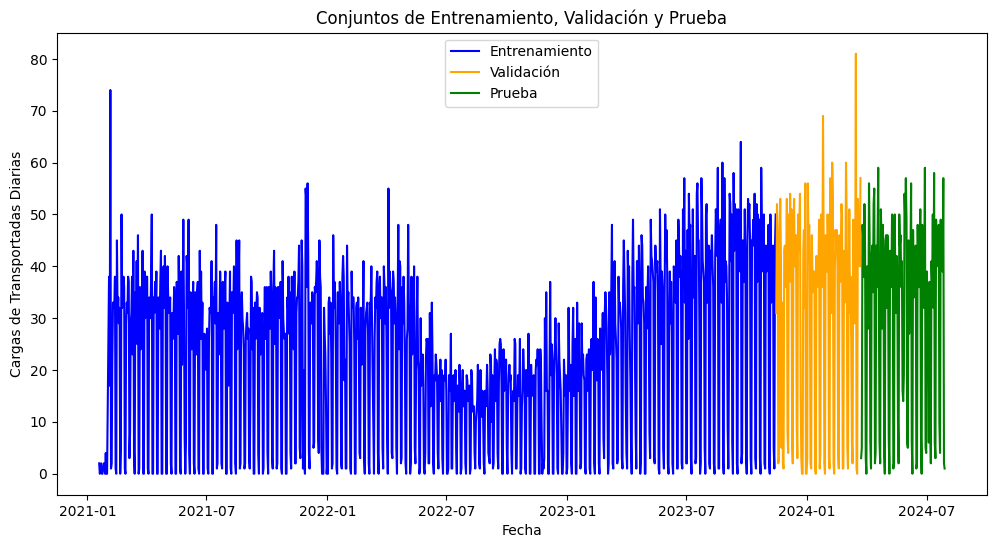

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, color='blue', label='Entrenamiento')
plt.plot(val.index, val, color='orange', label='Validación')
plt.plot(test.index, test, color='green', label='Prueba')

plt.title('Conjuntos de Entrenamiento, Validación y Prueba')
plt.xlabel('Fecha')
plt.ylabel('Cargas de Transportadas Diarias')
plt.legend()

plt.show()

In [ ]:
#explicar que siempre utilizaremos tanh y un batch size de 16

## 1. Recurrent neural networks

In [138]:
X_train, y_train = makeXy(train_esc, 3+1)
X_val, y_val = makeXy(val_esc, 3+1)
X_trainr, y_trainr = makeXy(train, 3+1)
X_valr, y_valr = makeXy(val, 3+1)

In [116]:
def create_RNN(neurons, shape, dropout_rate): #Creación RNN
    model_RNN = Sequential()
    model_RNN.add(SimpleRNN(neurons, input_shape=(shape,1), activation='tanh'))
    model_RNN.add(Dropout(dropout_rate))
    model_RNN.add(Dense(1, activation='linear'))
    model_RNN.compile(loss='mean_squared_error', optimizer='adam')

    return model_RNN

In [139]:
X_train.shape

(1026, 3, 1)

In [152]:
mod = create_RNN(100, 3, 0.4) # 3 es igual al shape del ciclo

In [142]:
save_weights_at = os.path.join('keras_models', f'{model.name}_weights_batch{batch_size}_{{epoch:02d}}-{{val_loss:.4f}}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch');

In [153]:
history_filename = os.path.join('historynn', f'history_{model.name}_batch{batch_size}.joblib')
history_airp = None

if os.path.exists(history_filename):
    history_filename = history_filename
    print("El archivo '{history_filename}' ya existe. Se ha cargado el historial del entrenamiento.")
        
else:
    history_airp = mod.fit(x=X_train, y=y_train, batch_size=16, epochs=25,
                             verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
                             shuffle=True);
    dump(history_airp.history, history_filename)
    print("El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'")

Epoch 1/25
65/65 - 3s - 52ms/step - loss: 0.0544 - val_loss: 0.0711
Epoch 2/25
65/65 - 1s - 13ms/step - loss: 0.0471 - val_loss: 0.0730
Epoch 3/25
65/65 - 1s - 10ms/step - loss: 0.0441 - val_loss: 0.0891
Epoch 4/25
65/65 - 0s - 6ms/step - loss: 0.0439 - val_loss: 0.0686
Epoch 5/25
65/65 - 0s - 5ms/step - loss: 0.0433 - val_loss: 0.0888
Epoch 6/25
65/65 - 0s - 5ms/step - loss: 0.0435 - val_loss: 0.0730
Epoch 7/25
65/65 - 0s - 5ms/step - loss: 0.0436 - val_loss: 0.0832
Epoch 8/25
65/65 - 0s - 6ms/step - loss: 0.0420 - val_loss: 0.0827
Epoch 9/25
65/65 - 0s - 6ms/step - loss: 0.0415 - val_loss: 0.0669
Epoch 10/25
65/65 - 0s - 5ms/step - loss: 0.0430 - val_loss: 0.0714
Epoch 11/25
65/65 - 0s - 5ms/step - loss: 0.0416 - val_loss: 0.1108
Epoch 12/25
65/65 - 0s - 5ms/step - loss: 0.0440 - val_loss: 0.0793
Epoch 13/25
65/65 - 0s - 6ms/step - loss: 0.0416 - val_loss: 0.0695
Epoch 14/25
65/65 - 1s - 10ms/step - loss: 0.0422 - val_loss: 0.0695
Epoch 15/25
65/65 - 0s - 5ms/step - loss: 0.0427 - va

In [154]:
model_dir = 'keras_models'
files = os.listdir(model_dir)
pattern = rf"{re.escape(model.name)}_weights_batch{batch_size}_(\d+)-([\d\.]+)\.keras"
    
best_val_loss = float('inf')
best_model_file = None
best_model = None
    
for file in files:
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_file = file
    
if best_model_file:
    best_model_path = os.path.join(model_dir, best_model_file)
    print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
    best_model = load_model(best_model_path)
else:
    print("No se encontraron archivos de modelos que coincidan con el patrón.")

Cargando el mejor modelo: functional_4_weights_batch16_09-0.0669.keras con val_loss: 0.0669


In [155]:
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


In [146]:
len(y_valr)

125

In [147]:
len(X_val)

125

In [148]:
pred_PRES.shape

(125,)

In [149]:
pred_PRES

array([18.970282, 23.86416 , 24.555058, 21.292133, 19.93622 , 18.276617,
       23.375505, 20.303093, 27.39524 , 25.71991 , 21.894808, 21.451092,
       19.480503, 19.314447, 17.554405, 23.99149 , 23.788376, 20.383902,
       21.903896, 16.428066, 19.562288, 16.600035, 24.294062, 24.241009,
       21.429808, 20.038857, 18.775476, 18.229267, 18.256054, 23.671282,
       24.417793, 20.316349, 21.387384, 17.256363, 16.8441  , 22.187515,
       23.803343, 27.203615, 28.14109 , 22.058376, 21.085   , 20.053524,
       16.402437, 25.48899 , 24.24812 , 27.93861 , 20.143702, 21.341953,
       16.85791 , 18.870214, 24.1692  , 25.208458, 21.455696, 22.316458,
       19.454273, 19.456375, 19.644789, 24.955719, 25.437044, 22.127632,
       22.724295, 19.30936 , 19.57927 , 17.97122 , 24.88805 , 24.133583,
       20.923779, 21.161985, 18.994692, 14.785134, 18.68631 , 22.76003 ,
       25.067545, 21.464388, 21.651833, 18.836123, 17.47542 , 18.55514 ,
       23.860643, 24.911146, 19.78928 , 22.380451, 

In [156]:
errors(pred_PRES, y_valr) #mae, mape, mse, rmse, r2

(19.254046493530275,
 inf,
 439.0886251465612,
 20.954441656760057,
 -0.017145156860351562)

In [73]:
shape = [3, 4] #Probamos inputs de 3 y 4 datos
neurons = [10, 50, 100]
ep = [10, 25]
drop_out = [0.2, 0.4, 0.6]

for s in shape:
    X_train, y_train = makeXy(train_esc, s+1)
    X_val, y_val = makeXy(val_esc, s+1)
    for n in neurons:
        for eph in ep:
            for dpout in drop_out:
                print("Esta combinación es", s, n, eph, dpout)

Esta combinación es 10 10 0.2
Esta combinación es 10 10 0.4
Esta combinación es 10 10 0.6
Esta combinación es 10 25 0.2
Esta combinación es 10 25 0.4
Esta combinación es 10 25 0.6
Esta combinación es 50 10 0.2
Esta combinación es 50 10 0.4
Esta combinación es 50 10 0.6
Esta combinación es 50 25 0.2
Esta combinación es 50 25 0.4
Esta combinación es 50 25 0.6
Esta combinación es 100 10 0.2
Esta combinación es 100 10 0.4
Esta combinación es 100 10 0.6
Esta combinación es 100 25 0.2
Esta combinación es 100 25 0.4
Esta combinación es 100 25 0.6
Esta combinación es 10 10 0.2
Esta combinación es 10 10 0.4
Esta combinación es 10 10 0.6
Esta combinación es 10 25 0.2
Esta combinación es 10 25 0.4
Esta combinación es 10 25 0.6
Esta combinación es 50 10 0.2
Esta combinación es 50 10 0.4
Esta combinación es 50 10 0.6
Esta combinación es 50 25 0.2
Esta combinación es 50 25 0.4
Esta combinación es 50 25 0.6
Esta combinación es 100 10 0.2
Esta combinación es 100 10 0.4
Esta combinación es 100 10 0.6
E

## 2. Multilayer Perceptron

In [151]:
#crear el modelo
def create_mlp(s, neurons, dropout_rate): #agregar como input shape
    
    input_layer = Input(shape=(s,), dtype='float32')
    hidden_layer = Dense(neurons, activation='tanh')(input_layer)
    dropout_layer = Dropout(dropout_rate)(input_layer)
    output_layer = Dense(1, activation='linear')(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [ ]:
mod = create_mlp(s, neurons, dropout_rate)

## 3. Long Short Term Memory

In [ ]:
#crear el modelo
def create_lstm(neurons, dropout_rate):
    
    input_layer = Input(shape=(7,1), dtype='float32')
    lstm_layer1 = LSTM(neurons, input_shape=(7,1), return_sequences=True)(input_layer)
    dropout_layer = Dropout(drop_out)(lstm_layer2)
    output_layer = Dense(1, activation='linear')(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

## 4. Seleccion mejor modelo

In [35]:
#Seleccionar el mejor modelo
# aca puede tocar cambiar las carpetas
def select_mlp(model, batch_size,X_train, y_train, X_val, y_val):

    save_weights_at = os.path.join('keras_models', f'{model.name}_weights_batch{batch_size}_{{epoch:02d}}-{{val_loss:.4f}}.keras')
    save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch');
    
    history_filename = os.path.join('historynn', f'history_{model.name}_batch{batch_size}.joblib')
    history_airp = None

    if os.path.exists(history_filename):
        history_filename = history_filename
        print("El archivo '{history_filename}' ya existe. Se ha cargado el historial del entrenamiento.")
        
    else:
        history_airp = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=10,
                 verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
                 shuffle=True);
        dump(history_airp.history, history_filename)
        print("El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'")

    model_dir = 'keras_models'
    files = os.listdir(model_dir)
    pattern = rf"{re.escape(model.name)}_weights_batch{batch_size}_(\d+)-([\d\.]+)\.keras"
    
    best_val_loss = float('inf')
    best_model_file = None
    best_model = None
    
    for file in files:
        match = re.match(pattern, file)
        if match:
            epoch = int(match.group(1))
            val_loss = float(match.group(2))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_file = file

    if best_model_file:
        best_model_path = os.path.join(model_dir, best_model_file)
        print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
        best_model = load_model(best_model_path)
    else:
        print("No se encontraron archivos de modelos que coincidan con el patrón.")

    return best_model

In [ ]:
#forecast
def forecast_nw(best_model, X_val):
    preds = best_model.predict(X_val)
    preds = scaler.inverse_transform(preds)
    preds = np.squeeze(preds)
    return preds

## 5. Implementación

In [41]:
#probar los distintos modelos
dropout_rates = [0.2, 0.4]#, 0.6, 0.8]
neurons_list = [10, 100]#, 1000, 10000]
batch_sizes = [16, 32]#, 64, 128]

val_result = []
test_result = []

#probar todas las combinaciones
for dropout_rate in dropout_rates:
    for neurons in neurons_list:
        for batch_size in batch_sizes:
            
            print(f"Evaluando: Neuronas: {neurons}, Dropout: {dropout_rate}, Batchsize: {batch_size}")
            model = create_mlp(neurons, dropout_rate)

            X_train, y_train = makeXy(train_esc, 8)
            X_val, y_val = makeXy(val_esc,8) #makeXy(ts, 5) #probar para 3, 4, 5

            #seleccionar el mejor modelo
            best_model = select_mlp(model, batch_size,X_train, y_train, X_val, y_val)

            #pronosticar validación
            val_pred = forecast_nw(best_model, X_val)
            mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, df_val['Price'].reset_index(drop=True).loc[7:])

            #calculo de residuos residuals = df_val['Price'].reset_index(drop=True).loc[7:]-pred_PRES
            #con mejor modelo se revisan supuestos del error en entrenamiento
            #con mejor modelo se revisan supuestos del error en test
            
            #con mejor modelo de esa combinación se predice test
            
            #pronosticar test
            #test_pred = forecast_nw(best_model, X_test)
            #mae_v, mape_v, mse_v, rmse_v, r2_v = errors(test_pred, df_test['Price'].reset_index(drop=True).loc[7:])

            #Se guardan los resultados
            #val_result.append(['price', "mlp", dropout_rate, neurons, batch_size, mape_v, mae_v, mse_v, rmse_v, r2_v]) #jb_pvalue_m, ljung_box_pvalue_m])
            #test_result.append(['price', "mlp", dropout_rate, neurons, batch_size, mape_t, mae_t, mse_t, rmse_t, r2_t, ljung_box_pvalue_t])
             
#dfval = pd.DataFrame(val_result, columns=['variable','model', 'val_size', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'jarque-bera_p','ljungbox_p'])
#dftest = pd.DataFrame(test_result, columns=['variable','model', 'test_size', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'ljungbox_p'])

Evaluando: Neuronas: 10, Dropout: 0.2, Batchsize: 16
Epoch 1/10
56/56 - 5s - 97ms/step - loss: 0.3895 - val_loss: 0.3581
Epoch 2/10
56/56 - 1s - 19ms/step - loss: 0.1277 - val_loss: 0.1940
Epoch 3/10
56/56 - 1s - 14ms/step - loss: 0.0946 - val_loss: 0.1535
Epoch 4/10
56/56 - 1s - 15ms/step - loss: 0.0824 - val_loss: 0.1238
Epoch 5/10
56/56 - 1s - 11ms/step - loss: 0.0666 - val_loss: 0.1024
Epoch 6/10
56/56 - 1s - 13ms/step - loss: 0.0562 - val_loss: 0.0911
Epoch 7/10
56/56 - 1s - 9ms/step - loss: 0.0477 - val_loss: 0.0714
Epoch 8/10
56/56 - 1s - 12ms/step - loss: 0.0435 - val_loss: 0.0609
Epoch 9/10
56/56 - 1s - 11ms/step - loss: 0.0354 - val_loss: 0.0491
Epoch 10/10
56/56 - 1s - 15ms/step - loss: 0.0309 - val_loss: 0.0486
El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'
Cargando el mejor modelo: functional_4_weights_batch16_10-0.0486.keras con val_loss: 0.0486
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


NameError: name 'df_val' is not defined

In [ ]:
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['Price'].reset_index(drop=True).loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted price')
plt.ylabel('Air Pressure')
plt.xlabel('Index');

In [ ]:
## organizar ciclo
## seleccionar mejor modelo por red neuronal hacer función default con carpetas que dependen del tipo de red
## guardar resultados validación y testing
## hacer modelo mejorado
## análisis de resultados
# subir jupyter book